# AKT3

In [61]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
from pyMLaux import plot_history, evaluate_regression_result, show_img_data
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

## Preparations

In [2]:
# avoid running int out of memory exceptions...
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# set data_dir here
data_dir = './resources/cards/'

## Generators

In [14]:
batch_size = 32 # default, but has been adapted while playing around... an example with 16 can be seen in README.md
img_size = (224, 224)
datagen = ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.05,
                                   zoom_range=0.05,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   cval=0
                             )
train_generator = datagen.flow_from_directory(f"{data_dir}/train", 
                                                    target_size=img_size, 
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = datagen.flow_from_directory(f"{data_dir}/valid",
                                                         target_size=img_size, 
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=(1. / 255))
test_generator = test_datagen.flow_from_directory(f"{data_dir}/test",
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


In [6]:
all_classes = list(train_generator.class_indices.keys())

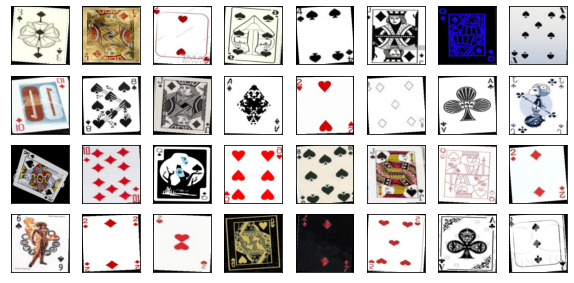

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# a quick look to make sure stuff works as intended
for img, label in train_generator:
  show_img_data(img, no=batch_size, layout=(8, 8))
  print(label)
  break

## Creating Models

In [21]:
def get_model(x):
  # index corresponding to model number in README.md (apart from 0 being pre-trained)
  if x == 0:
    resnet = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')
    resnet.trainable = False
    flat = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
    dense = tf.keras.layers.Dense(256, activation='relu')(flat)
    dropout = tf.keras.layers.Dropout(0.2)(dense)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout)
    dropout2 = tf.keras.layers.Dropout(0.2)(dense2)
    output = tf.keras.layers.Dense(len(all_classes), activation='softmax')(dropout2)
    m = tf.keras.models.Model(inputs=resnet.input, outputs=output)
    return m
  elif x == 1:
    m = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(48, (3, 3),
                            padding='same', activation='relu', input_shape=(224, 224, 3)),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(64, (3, 3),
                            padding='same', activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3),
                            padding='same', activation='relu'),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.Conv2D(196, (3, 3),
                           padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.10),
      # using global avg pooling instead of flattening
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.15),
      tf.keras.layers.Dense(128, activation='relu', use_bias=True),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation='softmax', use_bias=True),
    ])
    return m
  elif x == 2:
    m = tf.keras.models.Sequential([      
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(256, (2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation ='softmax')
    ])
    return m
  elif x == 3:
    m = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation ='softmax')
    ])
    return m
  elif x == 4:
    m = tf.keras.models.Sequential([      
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(256, (2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation ='softmax')
    ])
    return m
  elif x == 5:
    m = tf.keras.models.Sequential([      
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(256, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(256, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation ='softmax')
    ])
    return m
  elif x == 6:
    m = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(53, activation ='softmax')
    ])
    return m

## Training Models


In [23]:
filepath = './models/x4_{epoch:02d}-{categorical_accuracy:.4f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1,
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# specify model here
model = get_model(1)

model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=[tf.keras.metrics.categorical_accuracy])

history = model.fit(train_generator,
                    steps_per_epoch=(len(train_generator.filenames) // batch_size), 
                    epochs=10,
                    validation_data=validation_generator,
                    validation_freq=1,
                    validation_steps=(len(validation_generator.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/10
238/238 [==============================] - ETA: 0s - loss: 3.7383 - categorical_accuracy: 0.0533
Epoch 1: categorical_accuracy improved from -inf to 0.05335, saving model to ./models\x4_01-0.0533.hdf5
238/238 [==============================] - 73s 297ms/step - loss: 3.7383 - categorical_accuracy: 0.0533 - val_loss: 3.3178 - val_categorical_accuracy: 0.0742
Epoch 2/10
238/238 [==============================] - ETA: 0s - loss: 3.2503 - categorical_accuracy: 0.0911
Epoch 2: categorical_accuracy improved from 0.05335 to 0.09115, saving model to ./models\x4_02-0.0911.hdf5
238/238 [==============================] - 66s 277ms/step - loss: 3.2503 - categorical_accuracy: 0.0911 - val_loss: 3.0607 - val_categorical_accuracy: 0.1133
Epoch 3/10
238/238 [==============================] - ETA: 0s - loss: 2.9952 - categorical_accuracy: 0.1311
Epoch 3: categorical_accuracy improved from 0.09115 to 0.13106, saving model to ./models\x4_03-0.1311.hdf5
238/238 [==============================] -

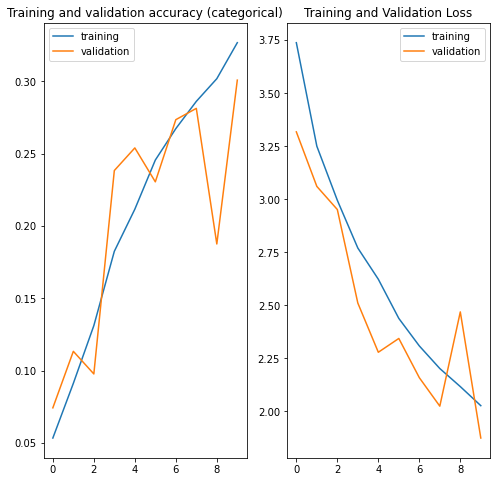

In [24]:
# plotting results
epochs_range = range(10)
accuracy=history.history['categorical_accuracy']
val_accuracy=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='training')
plt.plot(epochs_range, val_accuracy, label='validation')
plt.legend()
plt.title('Training and validation accuracy (categorical)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='training')
plt.plot(epochs_range, val_loss, label='validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Loading & Testing

#### Predicting a specific image

In [25]:
from keras.models import load_model
model = load_model('./models/x4/x4_10-0.7474.hdf5')

In [38]:
from tensorflow.keras.preprocessing import image

img_path = './resources/cards/test/four of hearts/1.jpg'
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


In [39]:
predict_x=model.predict(img_batch) 
classes_x=np.argmax(predict_x,axis=1)
print(class_map[classes_x[0]])

four of hearts


#### Predicting using the test generator

In [77]:
predict = model.predict(test_generator)
y_pred = predict.argmax(axis=-1)

In [75]:
y_test = test_generator.classes

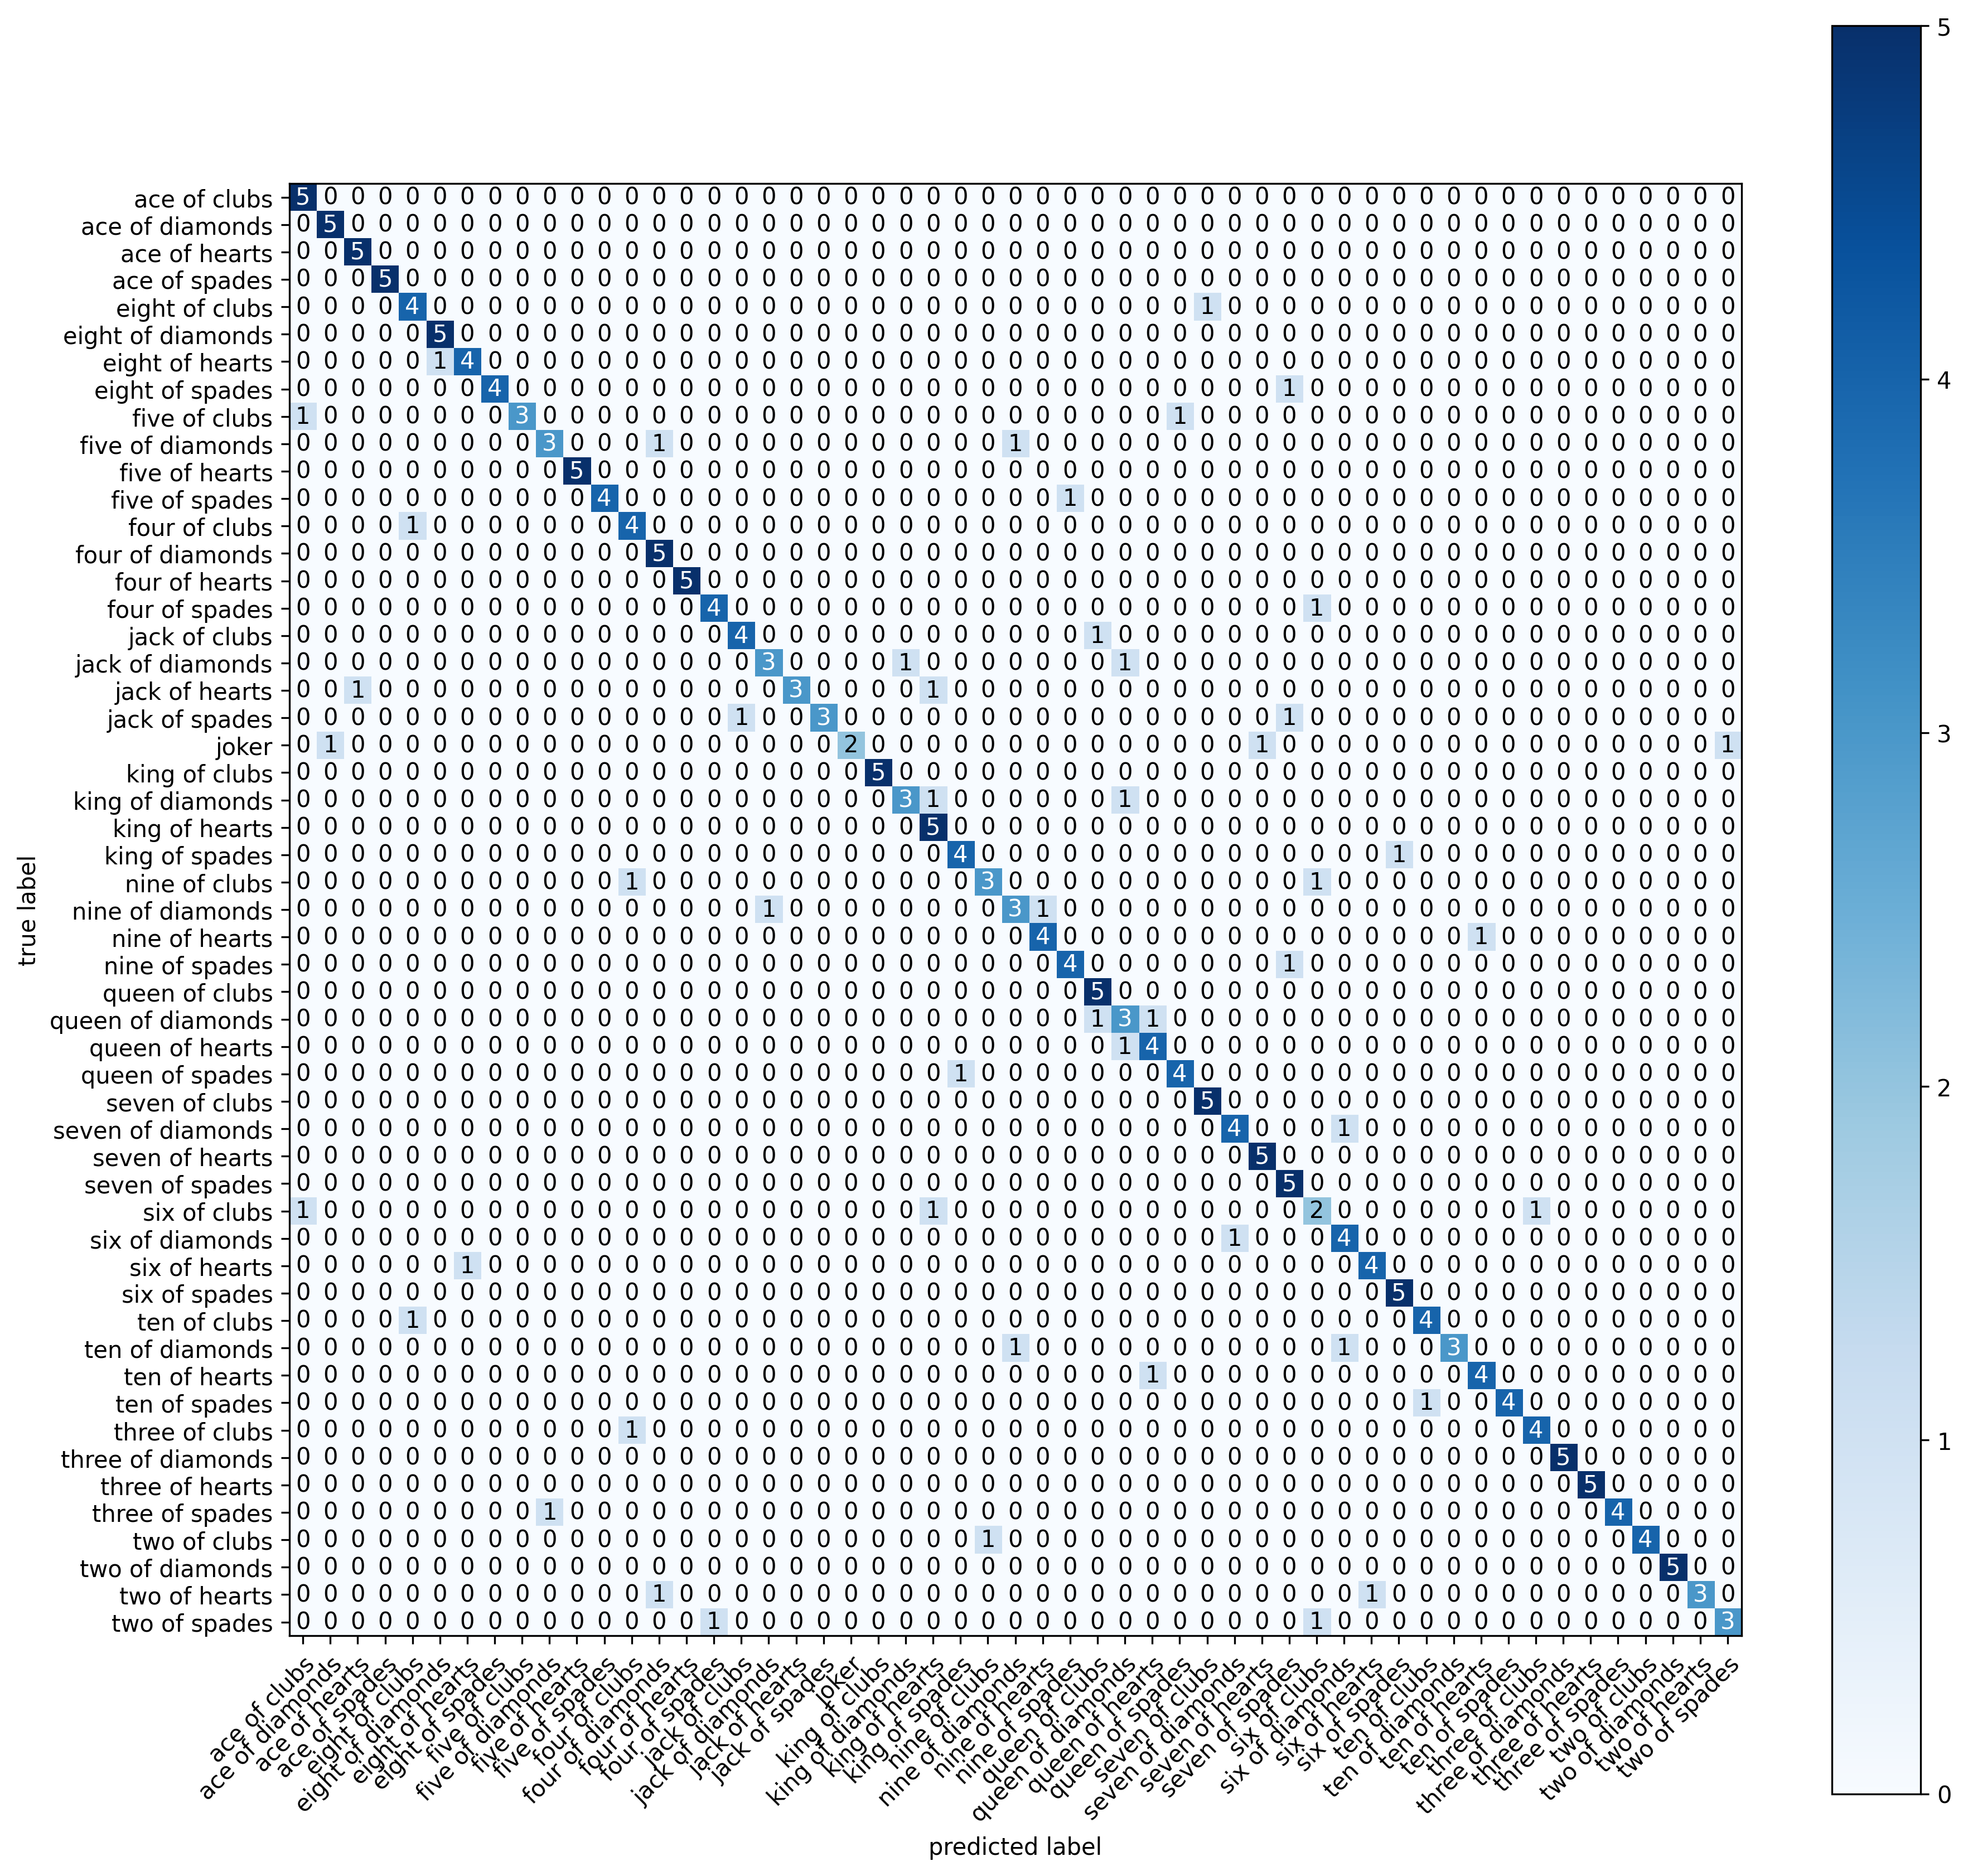

In [76]:
cm = confusion_matrix(y_test, y_pred, labels=None)
fig, ax= plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=all_classes,
                                figsize=(14,14,))
fig.set_dpi(300)

## Exporting

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/A6_E8_S2110454002.ipynb"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mi